### Edge based encoding

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from frites.plot import plot_conn_circle, plot_conn_heatmap
from frites.stats import confidence_interval
from frites.utils import parallel_func
from scipy.signal import fftconvolve
from tqdm import tqdm
from utils import *

from config import get_dates, return_delay_split
from GDa.flatmap.flatmap import flatmap
from GDa.graphics import plot
from GDa.loader import loader
from GDa.temporal_network import temporal_network
from GDa.util import _extract_roi, shuffle_along_axis

##### Setting configurations

In [3]:
_ROOT = os.path.expanduser("~/funcog/gda/")

In [4]:
metric = "coh"
monkey = "lucy"
ds = 1

In [38]:
sessions = get_dates(monkey)

In [39]:
reg_colors = dict(
    zip(
        [
            "motor",
            "parietal",
            "prefrontal",
            "somatosensory",
            "temporal",
            "visual",
            "auditory",
        ],
        ["r", "aqua", "b", "m", "goldenrod", "green", "brown"],
    )
)

In [40]:
stages = [[-0.4, 0], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stage_labels = ["P", "S", "D1", "D2", "Dm"]

In [41]:
bands = [[0, 6], [6, 14], [14, 26], [26, 42], [42, 80]]
band_names = ["theta", "alpha", "beta", "high-beta", "gamma"]

In [42]:
path_poh = os.path.expanduser("~/funcog/gda/Results/lucy/mutual_information/power")
path_coh = os.path.expanduser("~/funcog/gda/Results/lucy/mutual_information/coherence")

In [43]:
p_pow = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path_poh, "pval_pow_1_br_1_aligned_cue_avg_1_fdr_slvr_1.nc")
    )
)
t_pow = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path_poh, "tval_pow_1_br_1_aligned_cue_avg_1_fdr_slvr_1.nc")
    )
)

In [44]:
p_crk = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path_poh, "pval_crackle_1_br_1_aligned_cue_q_90_fdr.nc")
    )
)
t_crk = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path_poh, "tval_crackle_1_br_1_aligned_cue_q_90_fdr.nc")
    )
)

In [45]:
p_coh = node_xr_remove_sca(
    xr.load_dataarray(os.path.join(path_coh, "pval_coh_at_cue_avg_1_fdr.nc"))
)
t_coh = node_xr_remove_sca(
    xr.load_dataarray(os.path.join(path_coh, "tval_coh_at_cue_avg_1_fdr.nc"))
)

In [46]:
p_cc = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path_poh, "pval_cok_1_br_1_aligned_cue_avg_1_fdr_slvr_1.nc")
    )
)
t_cc = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path_poh, "tval_cok_1_br_1_aligned_cue_avg_1_fdr_slvr_1.nc")
    )
)

In [47]:
t_pow = t_pow * (p_pow <= 0.01)
t_coh = t_coh * (p_coh <= 0.01)
t_crk = t_crk * (p_crk <= 0.01)
t_cc = t_cc * (p_cc <= 0.01)

In [48]:
areas_dict = get_areas()
regions = np.asarray([areas_dict[roi.lower()] for roi in t_pow.roi.data])
idx = np.argsort(regions)
rois_order = t_pow.isel(roi=idx).roi

#### Does coherence encode the stimulus identity

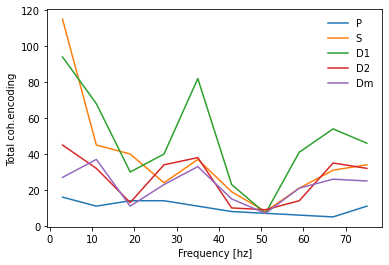

In [66]:
for t in range(5):
    plt.plot(t_coh.freqs, (p_coh.sel(times=t) <= 0.01).sum("roi"), label=stage_labels[t])
    plt.ylabel("Total coh.encoding")
    plt.xlabel("Frequency [hz]")
plt.legend(frameon=False)

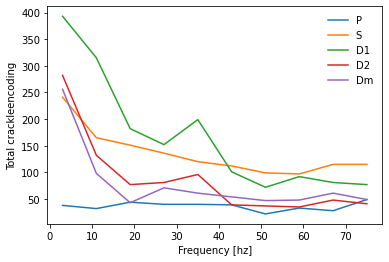

In [67]:
for t in range(5):
    plt.plot(t_cc.freqs, (p_cc.sel(times=t) <= 0.01).sum("roi"), label=stage_labels[t])
    plt.ylabel("Total crackleencoding")
    plt.xlabel("Frequency [hz]")
plt.legend(frameon=False)

In [ ]:
bins = np.linspace(1, 25, 100)
n, x = np.histogram(t_coh.sel(freqs=35, times=2).data, bins);
np, xp = np.histogram(t_cc.sel(freqs=35, times=2).data, bins);

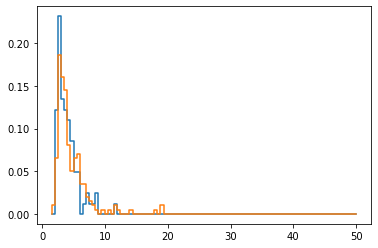

In [72]:
plt.step(x[1:], n / n.sum())
plt.step(xp[1:], np / np.sum())

In [20]:
import matplotlib


def plot_ring_plots(data_edges, data_nodes, time, freq, vmin=0, vmax=10):

    fig = plt.figure(figsize=(6, 3), dpi=300)

    nodes_size = data_nodes.sel(freqs=freq, times=time).sel(roi=rois_order)

    conn, rois = to_mat(
        data_edges.sel(freqs=freq, times=time).to_dataframe("mean_coh").reset_index(),
        "mean_coh",
    )

    conn = xr.DataArray(conn, dims=("sources", "targets"), coords=(rois, rois)).sel(
        sources=rois_order.data, targets=rois_order.data
    )

    node_colors = [reg_colors[areas_dict[roi.lower()]] for roi in rois_order.data]

    nodes_size = 10 * (nodes_size / np.max(nodes_size)) ** 2
    # conn = (conn / np.max(conn)) ** 3
    plot_conn_circle(
        conn,
        edges_cmap="hot_r",
        nodes_cmap="Greys",
        angle_span=360,
        nodes_size=nodes_size.data,
        nodes_label_fz=20,
        nodes_label_shift=0.3,
        nodes_label_color=node_colors,
        nodes_size_min=0,
        nodes_size_max=700,
        cbar=False,
        edges_vmin=vmin,
        edges_vmax=vmax,
        edges_lw=1,
    )

<Figure size 1800x900 with 0 Axes>

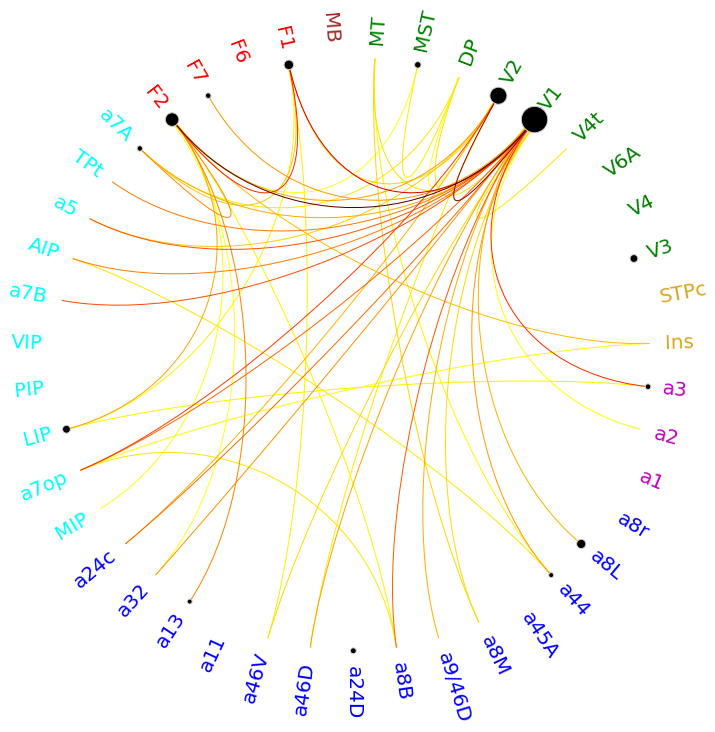

In [22]:
plot_ring_plots(t_coh, t_pow, 2, 35)

<Figure size 1800x900 with 0 Axes>

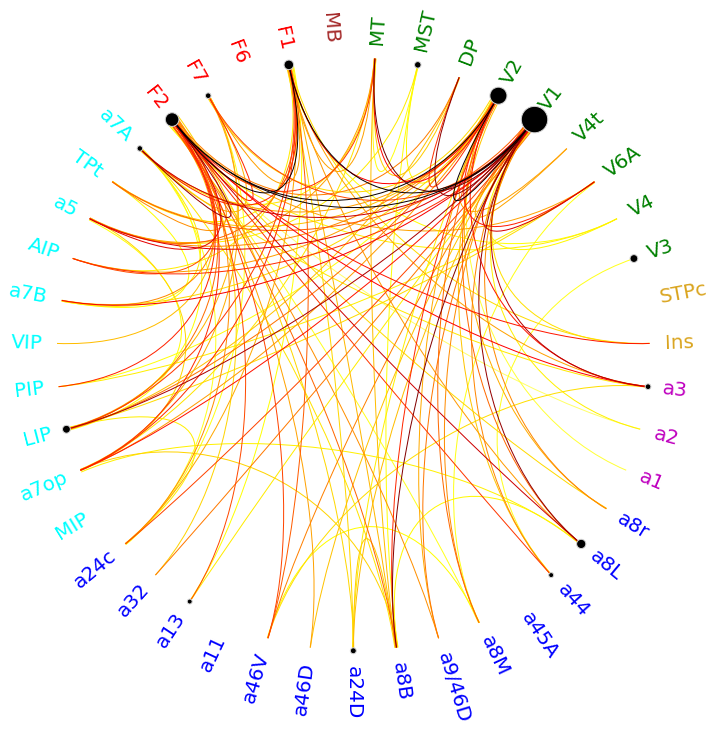

In [23]:
plot_ring_plots(t_cc, t_pow, 2, 35)

In [27]:
t = (p_coh <= 0.01).astype(int) + (p_cc <= 0.01).astype(int) * 2

<Figure size 1800x900 with 0 Axes>

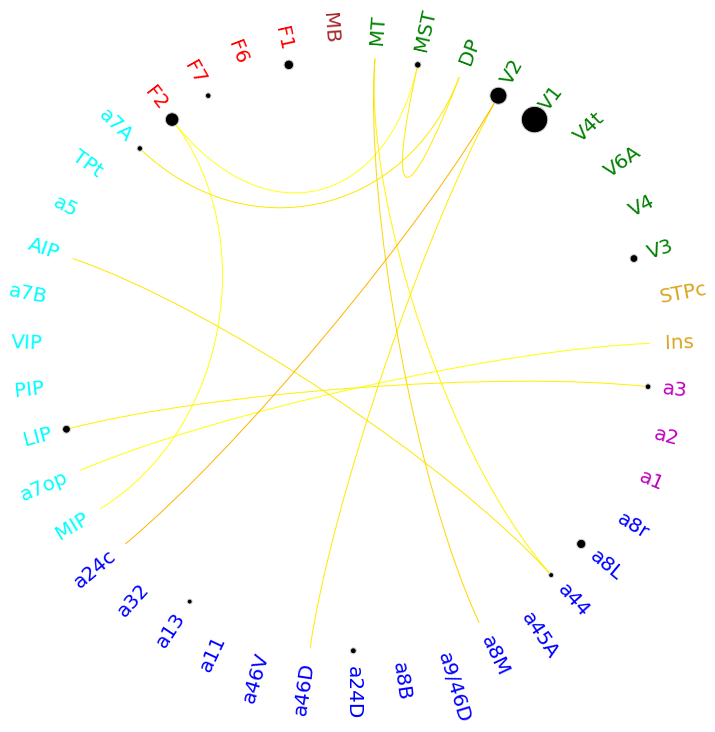

In [30]:
plot_ring_plots(t_coh * (t == 1), t_pow, 2, 35, vmin=0, vmax=10)

<Figure size 1800x900 with 0 Axes>

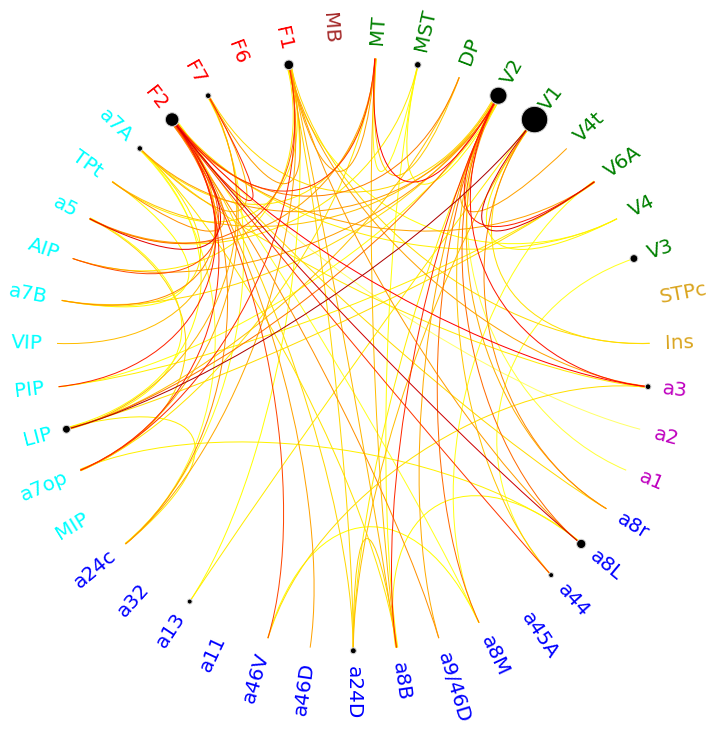

In [31]:
plot_ring_plots(t_cc * (t == 2), t_pow, 2, 35, vmin=0, vmax=10)

<Figure size 1800x900 with 0 Axes>

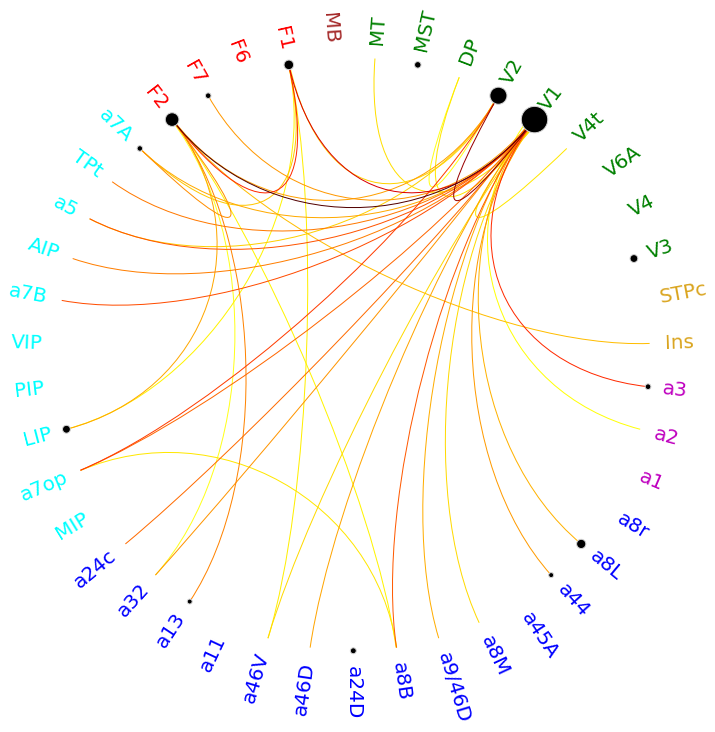

In [33]:
plot_ring_plots(t_coh * (t == 3), t_pow, 2, 35, vmin=0, vmax=10)

In [153]:
data_loader = loader(_ROOT=_ROOT)

kij = []
kij_surr = []
kij_st = []
Pb = []

for session in tqdm(sessions):
    kij += [data_loader.load_co_crakcle(session, trial_type=1, strength=True, thr=70)]
    kij_surr += [
        data_loader.load_co_crakcle(
            session, trial_type=1, strength=True, surrogate=True, thr=90
        )
    ]
    kij_st += [((kij[-1] - kij_surr[-1]) / (kij[-1] + kij_surr[-1]))]
    Pb += [data_loader.load_burst_prob(session=session)]

100%|██████████| 62/62 [00:11<00:00,  5.56it/s]


In [154]:
kij = xr.concat(kij, "roi").groupby("roi").mean("roi").sel(roi=rois_order)
kij_surr = xr.concat(kij_surr, "roi").groupby("roi").mean("roi").sel(roi=rois_order)
kij_st = xr.concat(kij_st, "roi").groupby("roi").mean("roi").sel(roi=rois_order)
Pb = xr.concat(Pb, "roi").groupby("roi").mean("roi").median("boot").sel(roi=rois_order)

In [98]:
pec = []
pec2 = []
for session in tqdm(sessions):
    temp = xr.load_dataarray(
        os.path.expanduser(f"~/funcog/gda/Results/lucy/pec/pec_st_{session}_at_cue.nc")
    )

    temp_2 = []
    for ti, tf in stages:
        temp_2 += [temp.sel(times=slice(ti, tf)).mean(("times", "trials"))]

    pec += [xr.concat(temp_2, "times")]

    temp = data_loader.load_pecst(
        session=session,
    )
    temp_2 = []
    for ti, tf in stages:
        temp_2 += [temp.sel(times=slice(ti, tf)).mean(("times", "trials"))]
    pec2 += [xr.concat(temp_2, "times")]

100%|██████████| 62/62 [01:11<00:00,  1.16s/it]


In [99]:
pec = xr.concat(pec, "roi").groupby("roi").mean("roi").sel(roi=rois_order)
pec2 = xr.concat(pec2, "roi").groupby("roi").mean("roi").sel(roi=rois_order)

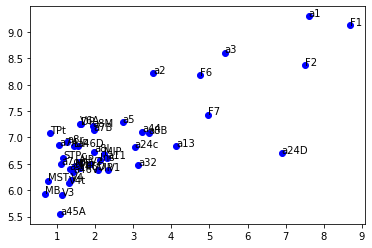

In [198]:
x = pec2.sel(times=2, freqs=35)
y = kij.sel(times=2, freqs=35)
for i in range(len(x)):
    plt.scatter(x[i], y[i], c="b")
    plt.text(x[i], y[i], kij_st.roi.data[i])

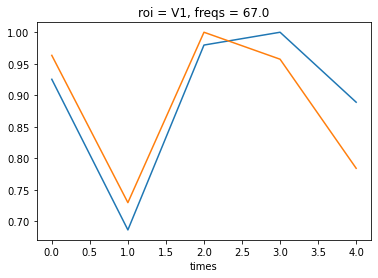

In [130]:
(pec.sel(freqs=67, roi="V1") / pec.sel(freqs=67, roi="V1").max()).plot()
(pec2.sel(freqs=67, roi="V1") / pec2.sel(freqs=67, roi="V1").max()).plot()

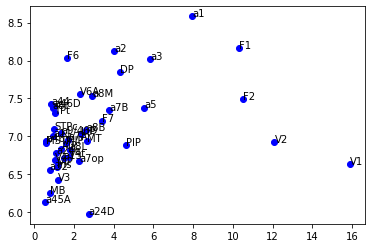

In [194]:
x = pec.sel(times=2, freqs=27)
y = kij.sel(times=2, freqs=27)
for i in range(len(x)):
    plt.scatter(x[i], y[i], c="b")
    plt.text(x[i], y[i], kij_st.roi.data[i])

In [201]:
plt.figure(figsize=(20, 20))
ccs = np.zeros((10, 5, 200))
pos = 1
for f in tqdm(range(10)):
    for t in range(5):
        conn, rois = to_mat(
            (p_coh.isel(freqs=f, times=t) <= 0.01).to_dataframe("mean_coh").reset_index(),
            "mean_coh",
        )

        conn = xr.DataArray(
            conn.astype(bool), dims=("sources", "targets"), coords=(rois, rois)
        ).sel(sources=rois_order.data, targets=rois_order.data)
        y = conn.sum("targets")


        ccs[f, t] = draw_bs_pairs_reps_pearson(
                pec.isel(freqs=f, times=t), y, 200
            )

 80%|████████  | 8/10 [00:04<00:01,  1.57it/s]/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


<Figure size 1440x1440 with 0 Axes>

In [202]:
ccs = confidence_interval(
    xr.DataArray(ccs, dims=("freqs", "times", "boot")), axis=2
).squeeze()

    Estimating CI (cis=[95], axis=2, n_boots=200, skipna=True, random_state=None)


[None, None]

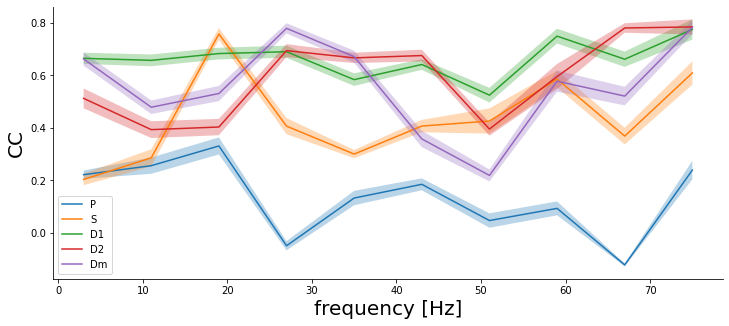

In [203]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(111)
for t in range(5):
    plt.plot(t_coh.freqs, ccs.sel(times=t).mean("bound"), label=stage_labels[t])
    plt.fill_between(
        t_coh.freqs,
        ccs.sel(bound="low", times=t),
        ccs.sel(bound="high", times=t),
        alpha=0.3,
    )

plt.legend()
plt.xlabel("frequency [Hz]", fontsize=20)
plt.ylabel("CC", fontsize=20)
plt.title("")
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

In [ ]:
plt.figure(figsize=(20, 20))
ccs = np.zeros((10, 5, 200))
pos = 1
for f in tqdm(range(10)):
    for t in range(5):
        ccs[f, t] = draw_bs_pairs_reps_pearson(
            pec.isel(freqs=f, times=t), kij.isel(freqs=f, times=t), 200
        )

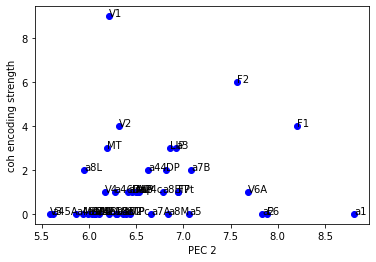

In [193]:
c = ["b", "orange", "g"]
for j, f in enumerate([35]):
    conn, rois = to_mat(
        (p_coh.sel(freqs=f, times=3) <= 0.01).to_dataframe("mean_coh").reset_index(),
        "mean_coh",
    )

    conn = xr.DataArray(
        conn.astype(bool), dims=("sources", "targets"), coords=(rois, rois)
    ).sel(sources=rois_order.data, targets=rois_order.data)

    x = (kij).sel(freqs=f, times=3)
    y = conn.sum("targets")
    for i in range(len(x)):
        plt.scatter(x[i], y[i], c="b")
        plt.text(x[i], y[i], kij_st.roi.data[i])

    plt.ylabel("coh encoding strength")
    plt.xlabel("PEC 2")

In [59]:
q5 = kij_surr.quantile(0.05, ("roi", "boot"))
q95 = kij_surr.quantile(0.95, ("roi", "boot"))

In [165]:
PEC = xr.load_dataarray(
    os.path.expanduser(f"~/funcog/gda/Results/lucy/pec/pec_st_141024_at_cue.nc")
)

In [171]:
KIJ = (
    data_loader.load_co_crakcle("141024", trial_type=1, strength=True, thr=70)
    .groupby("roi")
    .mean("roi")
)

In [173]:
KIJ.sel(roi="V1")

<xarray.DataArray (freqs: 10, times: 5)>
array([[18.13142898, 15.44827224, 11.5303026 , 16.70322642, 14.64192917],
       [15.0405546 , 14.3962247 , 12.33697976, 15.85863879, 15.31459527],
       [ 9.75984154, 12.67278541,  9.16907216, 10.33141466, 11.02603093],
       [10.74222031, 11.44719836,  9.22281405, 10.10818538, 10.295189  ],
       [11.00567488, 11.41021859,  9.114958  ,  9.96445685,  9.79020141],
       [ 9.12486636,  9.84593834,  8.83567679, 10.22904735,  9.90677262],
       [ 8.96518232,  9.602458  ,  8.39805269,  9.77289996,  9.52298587],
       [ 8.97666571,  9.66008496,  8.45119798,  9.93229286,  9.5094454 ],
       [ 9.29467354,  9.964853  ,  8.52715254, 10.02405021,  9.58379152],
       [ 9.03584383,  9.77174017,  8.53735204, 10.09177167,  9.63394903]])
Coordinates:
    quantile  float64 0.7
  * freqs     (freqs) float64 3.0 11.0 19.0 27.0 35.0 43.0 51.0 59.0 67.0 75.0
    roi       <U2 'V1'
Dimensions without coordinates: times

In [ ]:
data = np.stack(
    [
        Pb_t.sel(freqs=35, times=2).data,
        kij.sel(freqs=35, times=2).data,
        conn.sum("targets"),
    ]
).T

NameError: name 'Pb_t' is not defined

In [104]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

regr = SVR(C=1.0, epsilon=0.1)
regr.fit(data[:, :2], data[:, -1])

SVR()

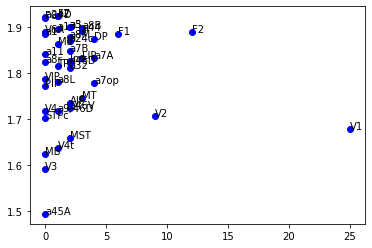

In [105]:
x = regr.predict(data[:, :2])
y = data[:, -1]
for i in range(len(x)):
    plt.scatter(y[i], x[i], c="b")
    plt.text(y[i], x[i], Pb_t.roi.data[i])

array([ 0.,  6.,  0.,  1., 12.,  4.,  1.,  2.,  2.,  2.,  0.,  0.,  3.,
        4.,  1.,  2.,  2.,  1.,  0.,  2.,  2.,  0.,  3.,  1.,  2.,  0.,
        3.,  1.,  0.,  0.,  1.,  2.,  2.,  0.,  0.,  0.,  0.,  1., 25.,
        9.,  4.,  2.,  3.])

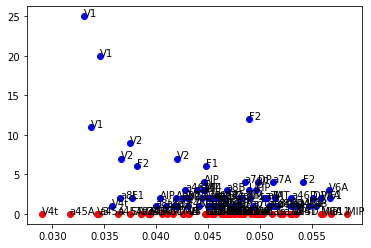

In [78]:
for f in [27, 35, 43]:

    nodes_size = kij.sel(
        freqs=f, times=2
    )  # t_pow.sel(freqs=35, times=3).sel(roi=rois_order)
    nodes_colors = [reg_colors[areas_dict[roi.lower()]] for roi in rois_order.data]

    conn_list = []

    conn, rois = to_mat(
        t_coh.sel(freqs=f, times=2).to_dataframe("mean_coh").reset_index(),
        "mean_coh",
    )

    conn = xr.DataArray(
        conn.astype(bool), dims=("sources", "targets"), coords=(rois, rois)
    ).sel(sources=rois_order.data, targets=rois_order.data)

    conn_list += [conn.astype(bool)]

    #  conn = np.logical_or(np.logical_or(conn_list[0], conn_list[1]), conn_list[2])

    """plot_conn_circle(
        conn,
        edges_cmap="binary",
        nodes_cmap="Greys",
        angle_span=360,
        nodes_size=nodes_size.data,
        nodes_label_fz=12,
        nodes_label_shift=0.3,
        nodes_label_color=nodes_colors,
        nodes_size_min=0,
        nodes_size_max=400,
        cbar=False,
        edges_lw=5
    )"""

    connp, rois = to_mat(
        (p_coh.sel(freqs=f, times=2) <= 0.01).to_dataframe("mean_coh").reset_index(),
        "mean_coh",
    )

    connp = xr.DataArray(
        connp.astype(bool), dims=("sources", "targets"), coords=(rois, rois)
    ).sel(sources=rois_order.data, targets=rois_order.data)

    colors = np.array(["r", "b"])[(connp.sum(axis=1) > 0).astype(int)]

    for i, c in enumerate(colors):
        plt.scatter(
            x=Pb_t.sel(freqs=f, times=2).data[i], y=conn.sum(axis=1).data[i], color=c
        )
        plt.text(
            Pb_t.sel(freqs=f, times=2).data[i],
            conn.sum(axis=1).data[i],
            kij.roi.data[i],
        )

In [49]:
pec

NameError: name 'pec' is not defined

In [65]:
rois = p_coh.roi.data
roi_s, roi_t = _extract_roi(rois, "-")

In [66]:
ov = []
coords = []
for p, (s, t) in enumerate(zip(roi_s, roi_t)):
    try:
        p_pow_s = (p_pow.sel(roi=s) <= 0.01).astype(int).data
        p_pow_t = (p_pow.sel(roi=t) <= 0.01).astype(int).data

        p_coh_st = (p_coh.isel(roi=p) <= 0.01).astype(int).data

        x = np.logical_and(p_coh_st, np.logical_or(p_pow_s, p_pow_t))
        y = (p_coh_st + p_pow_s + p_pow_t) == 3

        ov += [np.logical_or(x, y)]
        coords += [f"{s}-{t}"]
    except:
        continue

In [67]:
ov = xr.DataArray(
    ov, dims=("roi", "freqs", "times"), coords=dict(roi=coords, freqs=p_cc.freqs)
)

    Estimating CI (cis=[95], axis=0, n_boots=200, skipna=True, random_state=None)


[None, None]

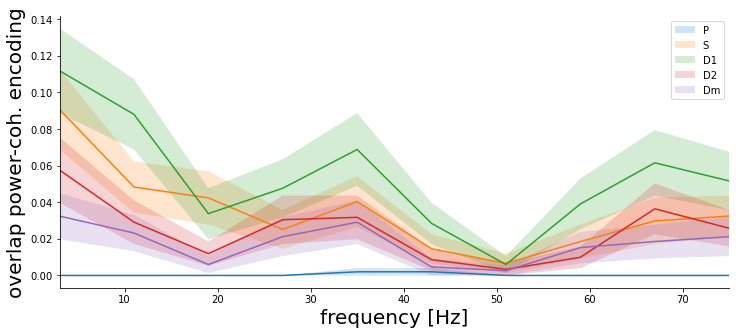

In [68]:
plt.figure(figsize=(12, 5))
ci = confidence_interval(xr.concat(ov, "roi"), axis=0).squeeze()
ax = plt.subplot(111)
for t in range(5):
    ci.sel(times=t).median("bound").plot(x="freqs")
    plt.fill_between(
        t_coh.freqs,
        ci.sel(times=t, bound="low"),
        ci.sel(times=t, bound="high"),
        alpha=0.2,
        label=stage_labels[t],
    )
plt.xlim(3, 75)
plt.legend()
plt.xlabel("frequency [Hz]", fontsize=20)
plt.ylabel("overlap power-coh. encoding", fontsize=20)
plt.title("")
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

### Is coherence and coherence encoding linked to crackling

In [ ]:
coh_file = f"pec_at_cue.nc"
# coh_sig_file = f"thr_coh_at_cue_surr.nc"

net = temporal_network(
    coh_file=coh_file,
    coh_sig_file=None,
    wt=None,
    date="141024",
    trial_type=[1],
    behavioral_response=[1],
)

In [ ]:
out = []
for t0, tf in stages:
    out += [
        edge_xr_remove_sca(
            xr_remove_same_roi(
                net.super_tensor.sel(times=slice(t0, tf)).mean(("times", "trials"))
            )
        )
    ]

In [ ]:
out = xr.concat(out, "times")

In [ ]:
out = out.groupby("roi").mean("roi")

In [ ]:
cc_s_tf = []
kij_s_vec = []
for tt in [1, 2]:

    kij = data_loader.load_co_crakcle(session="141024", trial_type=tt, strength=False)

    nrois, _, nfreqs, ntimes = kij.shape
    rois, freqs, times = kij.sources.data, kij.freqs.data, kij.times.data
    i, j = net.super_tensor.attrs["sources"], net.super_tensor.attrs["targets"]
    edges = [f"{s}-{t}" for s, t in zip(rois[i], rois[j])]

    kij_s = np.zeros((len(i), nfreqs, ntimes))

    for p, (s, t) in enumerate(zip(i, j)):
        kij_s[p, ...] = kij[s, t, ...]

    kij_s = xr.DataArray(
        kij_s, dims=("roi", "freqs", "times"), coords=(edges, freqs, times)
    )

    kij_s = edge_xr_remove_sca(xr_remove_same_roi(kij_s))

    cc_s = np.zeros((2, 10, 5))
    for f in range(10):
        for t in range(5):
            cc_s[:, f, t] = confidence_interval(
                draw_bs_pairs_reps_pearson(
                    kij_s.groupby("roi").mean("roi").sel(times=t).isel(freqs=f).data,
                    np.log(out.sel(times=t).isel(freqs=f).data),
                    size=1000,
                ),
                verbose=False,
            )

    cc_s_tf += [cc_s]
    kij_s_vec += [kij_s]

In [75]:
def plot_circle_encoding(ax, freq, time):

    areas_dict = get_areas()
    regions = np.asarray([areas_dict[roi.lower()] for roi in t_pow.roi.data])
    idx = np.argsort(regions)
    rois_order = t_pow.isel(roi=idx).roi

    nodes_size = t_pow.sel(freqs=freq, times=time).sel(roi=rois_order)

    conn, rois = to_mat(
        t_coh.sel(freqs=freqs, times=time).to_dataframe("mean_coh").reset_index(),
        "mean_coh",
    )

    conn = xr.DataArray(conn, dims=("sources", "targets"), coords=(rois, rois)).sel(
        sources=rois_order.data, targets=rois_order.data
    )

    # nodes_size = 10 * (nodes_size / np.max(nodes_size)) ** 2
    conn = (conn / t_coh.sel(freqs=35).max()) ** 5

    plot_conn_circle(
        conn,
        edges_cmap="hot_r",
        nodes_cmap="Greys",
        angle_span=360,
        nodes_size=nodes_size.data,
        nodes_label_fz=5,
        nodes_label_shift=0.3,
        nodes_size_min=0,
        nodes_size_max=10,
        cbar=False,
        edges_vmin=0,
        edges_vmax=.,
        edges_lw=1,
        ax=ax,
    )

In [ ]:
import matplotlib

fig = plt.figure(figsize=(8, 6), dpi=600)

gs0 = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.95, bottom=0.7, top=0.95)

# gs0_ax = fig.add_gridspec(nrows=1, ncols=1, left=0.92, right=0.93, bottom=0.7, top=0.87)

gs1 = fig.add_gridspec(
    nrows=1, ncols=2, left=0.05, right=0.95, bottom=0.38, top=0.58, wspace=0.2
)

gs2 = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.95, bottom=0.05, top=0.25)

axs0 = [plt.subplot(gs0[i]) for i in range(5)]
# axs0_ax = plt.subplot(gs0_ax[0])
axs1 = [plt.subplot(gs1[i]) for i in range(2)]
axs2 = [plt.subplot(gs2[i], polar=True) for i in range(5)]

################################################################################################
# Plot networks
################################################################################################
for time, ax in enumerate(axs2):
    plot_circle_encoding(ax, 35, time)
    plt.title(f"{stage_labels[time]}", fontsize=10, pad=10)
"""
norm = matplotlib.colors.Normalize(vmin=0, vmax=8)
cmap = matplotlib.cm.get_cmap("hot_r")

cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ticks=[0, 5],
    cax=axs0_ax,
    extend="max",
)
cbar.ax.set_ylabel("Edge encoding [a.u]", fontsize=8, rotation=270, labelpad=6)
"""

################################################################################################
# Scatter plots
################################################################################################
for pos, (fl, fh) in enumerate(bands):
    for t in range(5):
        plt.sca(axs0[pos])
        sns.regplot(
            x=kij_s_vec[0]
            .groupby("roi")
            .mean("roi")
            .sel(times=t)
            .sel(freqs=slice(fl, fh))
            .data.flatten(),
            y=np.log(out.sel(times=t).sel(freqs=slice(fl, fh)).data.flatten()),
            ci=None,
            scatter_kws={"s": 1},
            label=f"{stage_labels[t]}",
        )
        plt.ylim(-6.1, -2)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)

    plt.xticks([0, 0.12])
    plt.yticks([-6, -2])
    if pos > 0:
        plt.setp(axs0[pos].get_yticklabels(), visible=False)
    else:
        plt.ylabel("log(coherence)", fontsize=8, labelpad=0)
    plt.xlabel("Crackle probability", fontsize=8)
    plt.title(f"{band_names[pos]}", fontsize=8, pad=-1)
axs0[pos].legend(
    loc="right",
    bbox_to_anchor=(1.35, 0.5),
    ncol=1,
    fontsize=6,
    frameon=False,
    handletextpad=0.1,
)

[axs0[pos].spines["top"].set_visible(False) for pos in range(5)]
[axs0[pos].spines["right"].set_visible(False) for pos in range(5)]

################################################################################################
# Correlations
################################################################################################
titles = ["task", "fixation"]
for pos in range(2):
    plt.sca(axs1[pos])
    [plt.plot(kij_s.freqs, cc_s_tf[pos][..., t].mean(0), lw=0.3) for t in range(5)]
    [
        plt.fill_between(
            kij_s.freqs, cc_s_tf[pos][0, :, t], cc_s_tf[pos][1, :, t], alpha=0.4
        )
        for t in range(5)
    ]
    if pos == 0:
        plt.ylabel("CC[log(coh), kij]", fontsize=8, labelpad=-8)
    plt.xlim(3, 75)
    plt.xticks(t_coh.freqs.data, fontsize=8)
    plt.yticks([-0.2, 0.8], fontsize=8)
    plt.title(f"{titles[pos]}", fontsize=8, pad=0)
    plt.ylim([-0.2, 0.8])
    plt.xlabel("frequency [Hz]")
[axs1[pos].spines["top"].set_visible(False) for pos in range(2)]
[axs1[pos].spines["right"].set_visible(False) for pos in range(2)]


plot.add_panel_letters(
    fig,
    axes=axs0 + axs1 + axs2,
    fontsize=12,
    xpos=[-0.1] * 5 + [-0.0] * 2 + [-0.1] * 5,
    ypos=[1.05] * 7 + [1.0] * 5,
)

bg = plot.Background(visible=False)

plt.savefig("figures/n6/figure14.pdf")

In [45]:
def plot_circle_encoding(ax, tvals, tvals_node, freq, time):

    areas_dict = get_areas()
    regions = np.asarray([areas_dict[roi.lower()] for roi in t_pow.roi.data])
    idx = np.argsort(regions)
    rois_order = tvals_node.isel(roi=idx).roi

    nodes_size = tvals_node.sel(freqs=freq, times=time).sel(roi=rois_order)

    conn, rois = to_mat(
        tvals.sel(freqs=freq, times=time).to_dataframe("mean_coh").reset_index(),
        "mean_coh",
    )

    conn = xr.DataArray(conn, dims=("sources", "targets"), coords=(rois, rois)).sel(
        sources=rois_order.data, targets=rois_order.data
    )

    # nodes_size = 10 * (nodes_size / np.max(nodes_size)) ** 2
    conn = (conn / tvals.sel(freqs=freq).max()) ** 5

    plot_conn_circle(
        conn,
        edges_cmap="hot_r",
        nodes_cmap="Greys",
        angle_span=360,
        nodes_size=nodes_size.data,
        nodes_label_fz=5,
        nodes_label_shift=0.3,
        nodes_size_min=0,
        nodes_size_max=10,
        cbar=False,
        edges_vmin=0,
        edges_vmax=0.1,
        edges_lw=1,
        ax=ax,
    )

In [46]:
freqs = t_coh.freqs.values

/home/vinicius/Documents/frites/frites/utils/preproc.py:375: RuntimeWarning: invalid value encountered in true_divide
  x_n = x * to_max / xh
/home/vinicius/Documents/frites/frites/utils/preproc.py:375: RuntimeWarning: invalid value encountered in true_divide
  x_n = x * to_max / xh
/home/vinicius/Documents/frites/frites/utils/preproc.py:375: RuntimeWarning: invalid value encountered in true_divide
  x_n = x * to_max / xh
/home/vinicius/Documents/frites/frites/utils/preproc.py:375: RuntimeWarning: invalid value encountered in true_divide
  x_n = x * to_max / xh
/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/vinicius/Documents/frites/frites/utils/preproc.py:375: RuntimeWarning: invalid value encountered in true_divide
  x_n = x * to_max / xh
/home/vinicius/Documents/frites/frites/utils/preproc.py:375: RuntimeWarning: invalid val

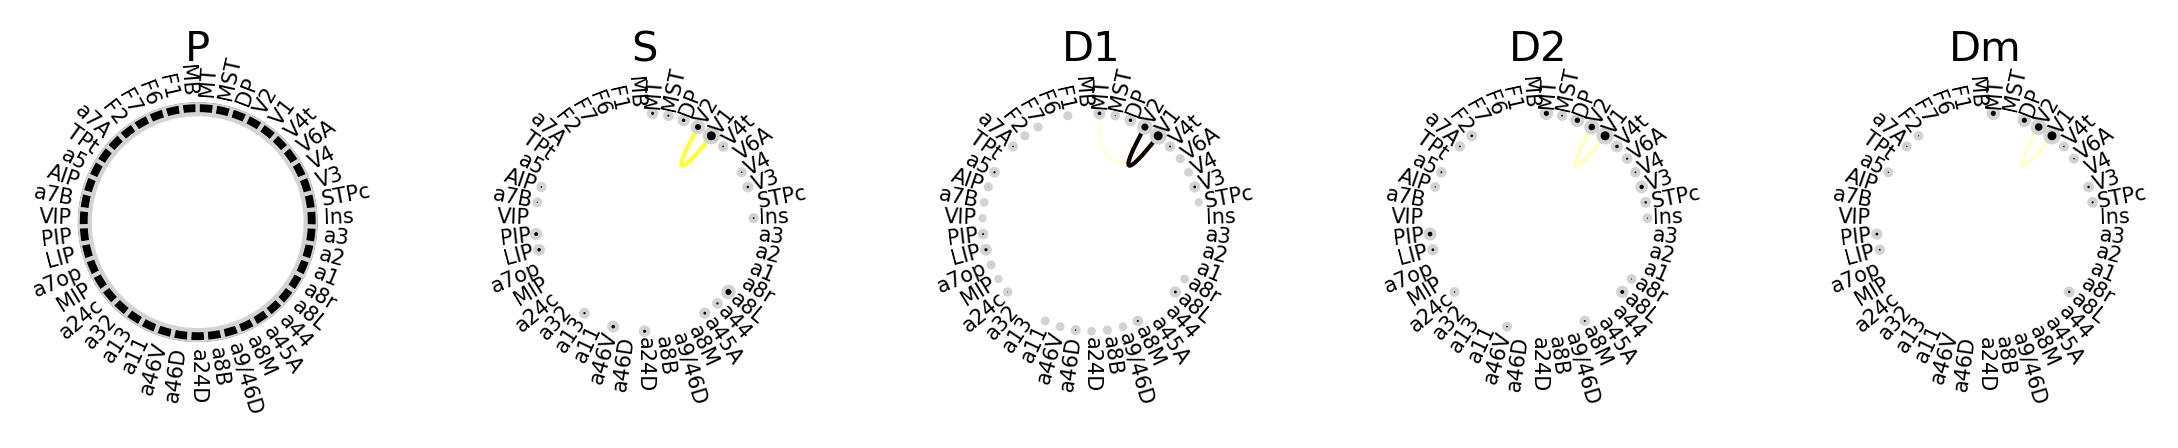

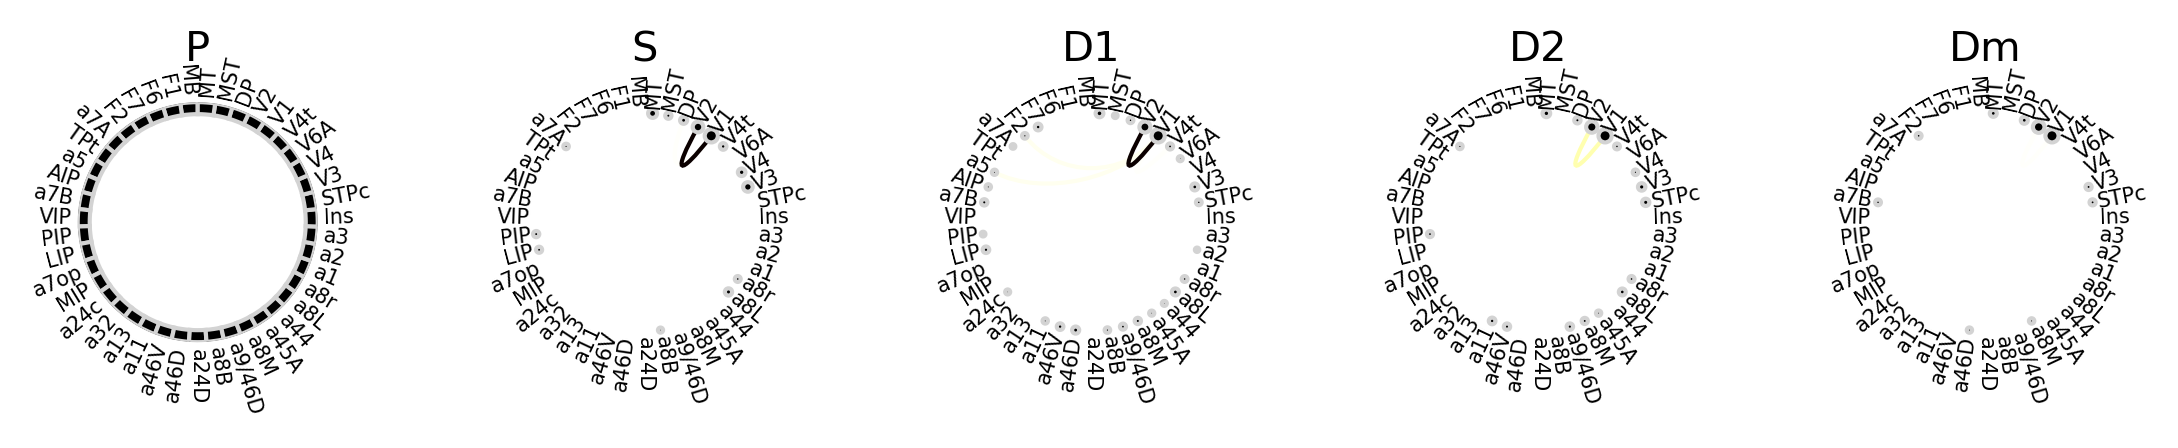

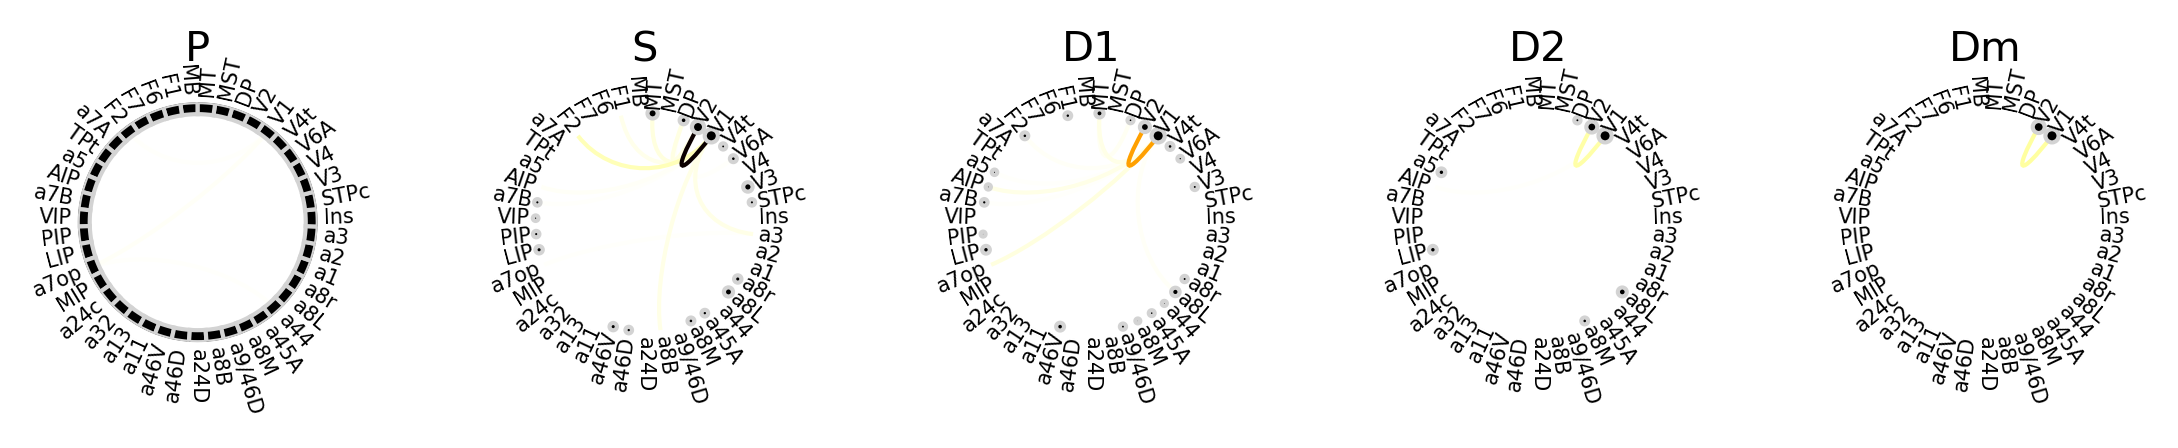

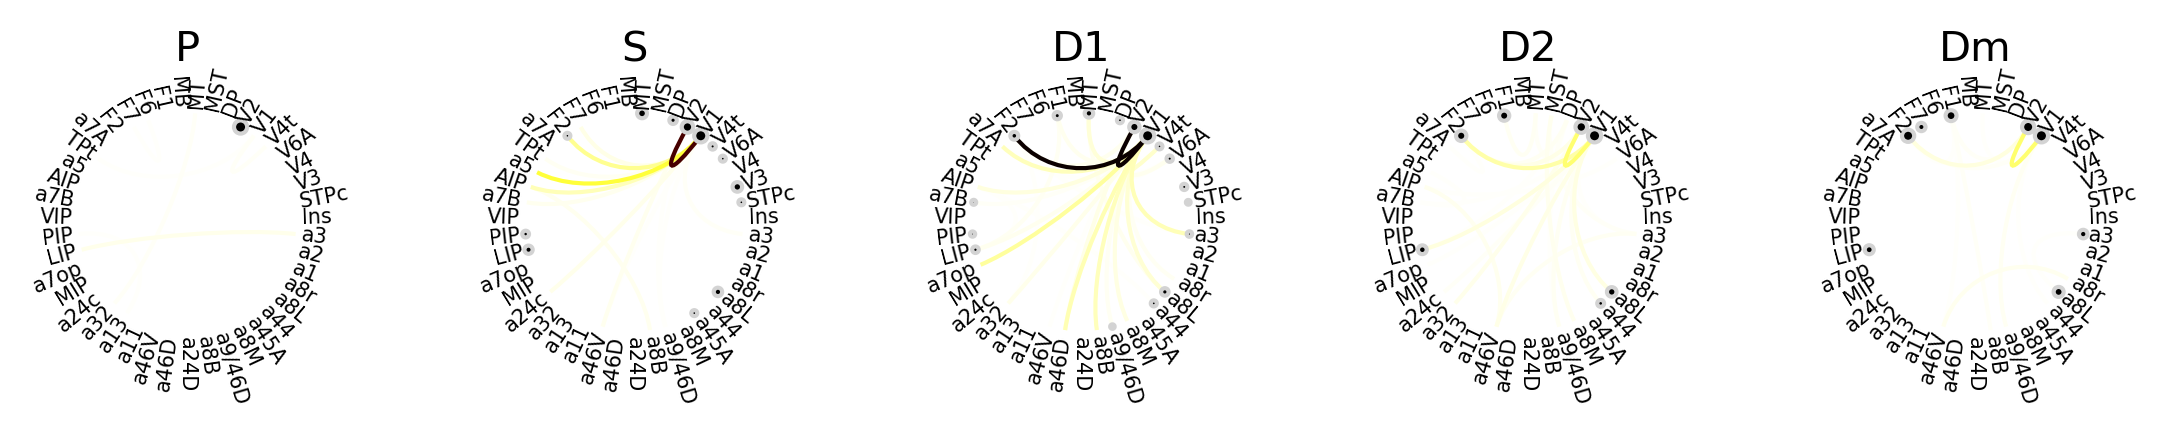

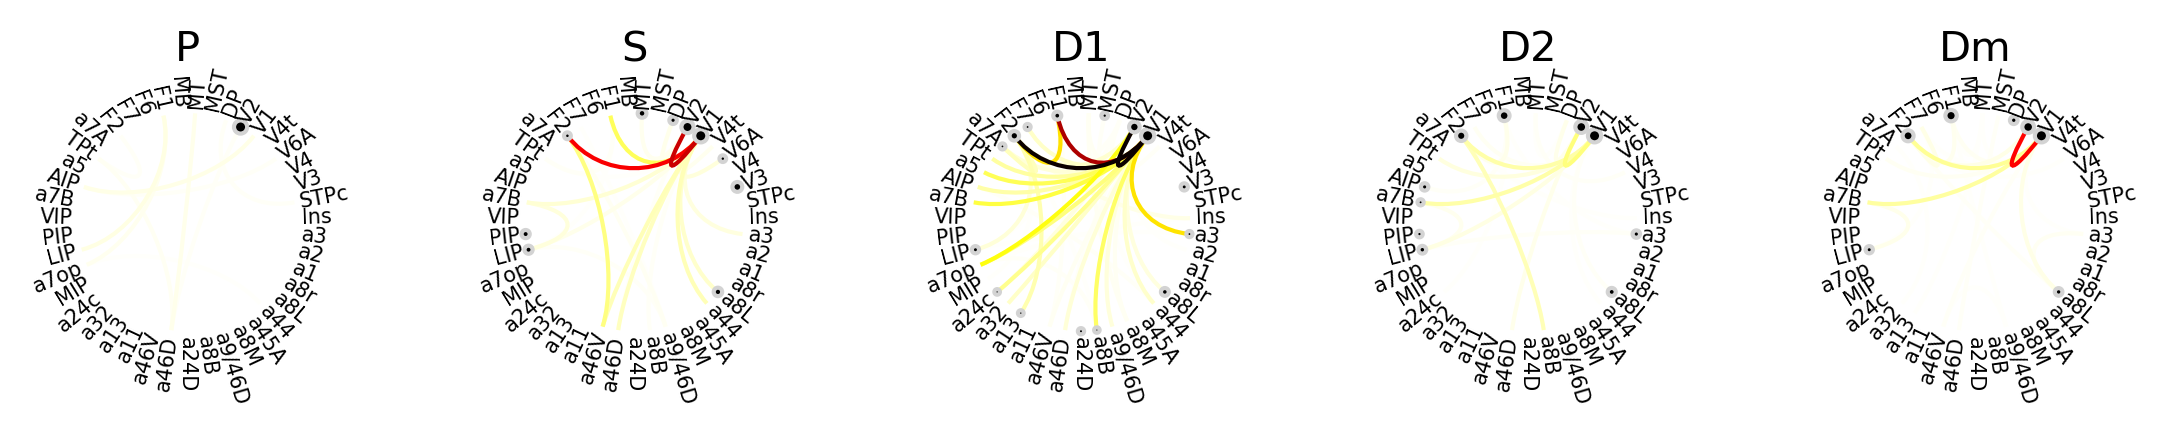

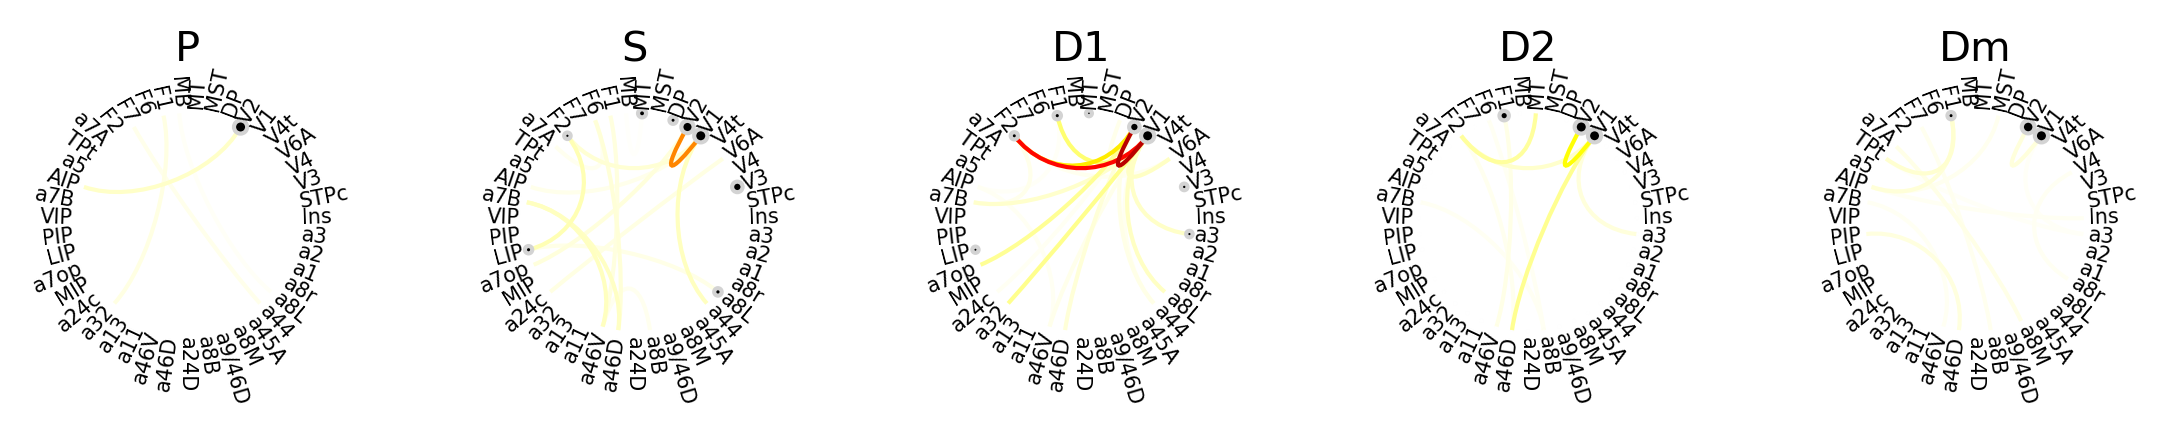

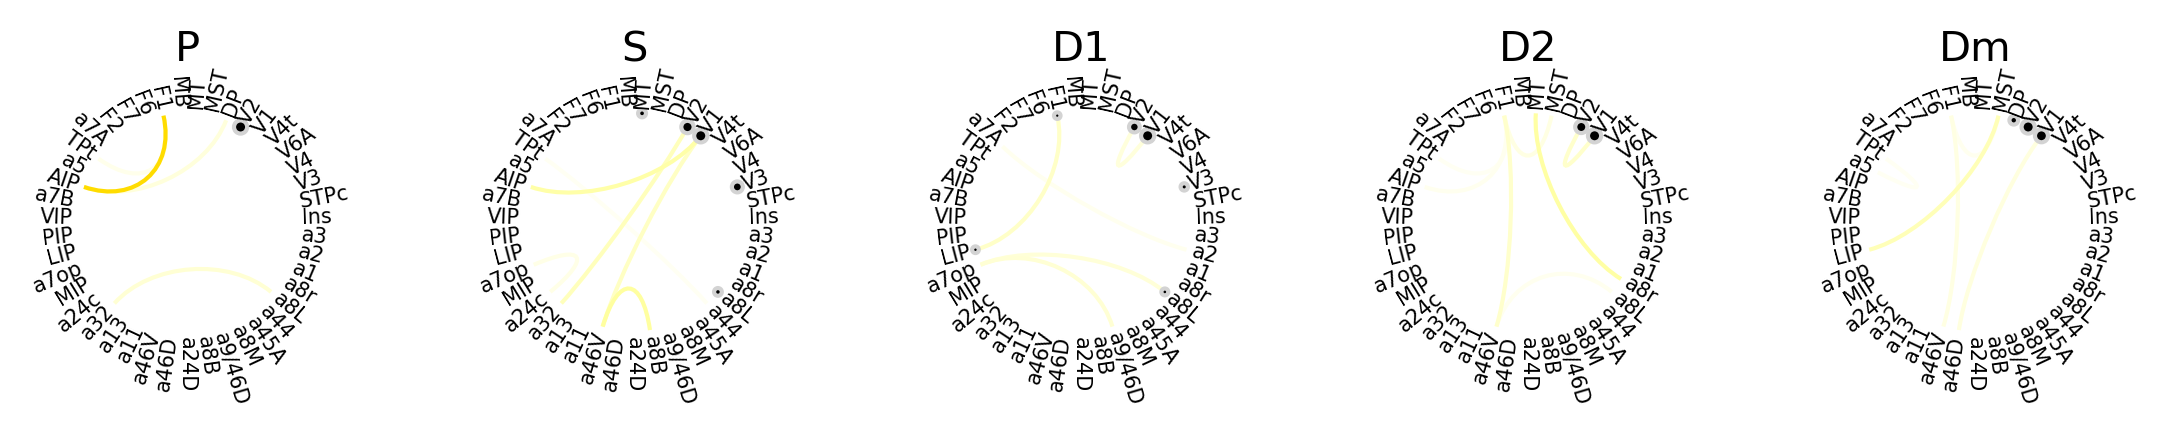

/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


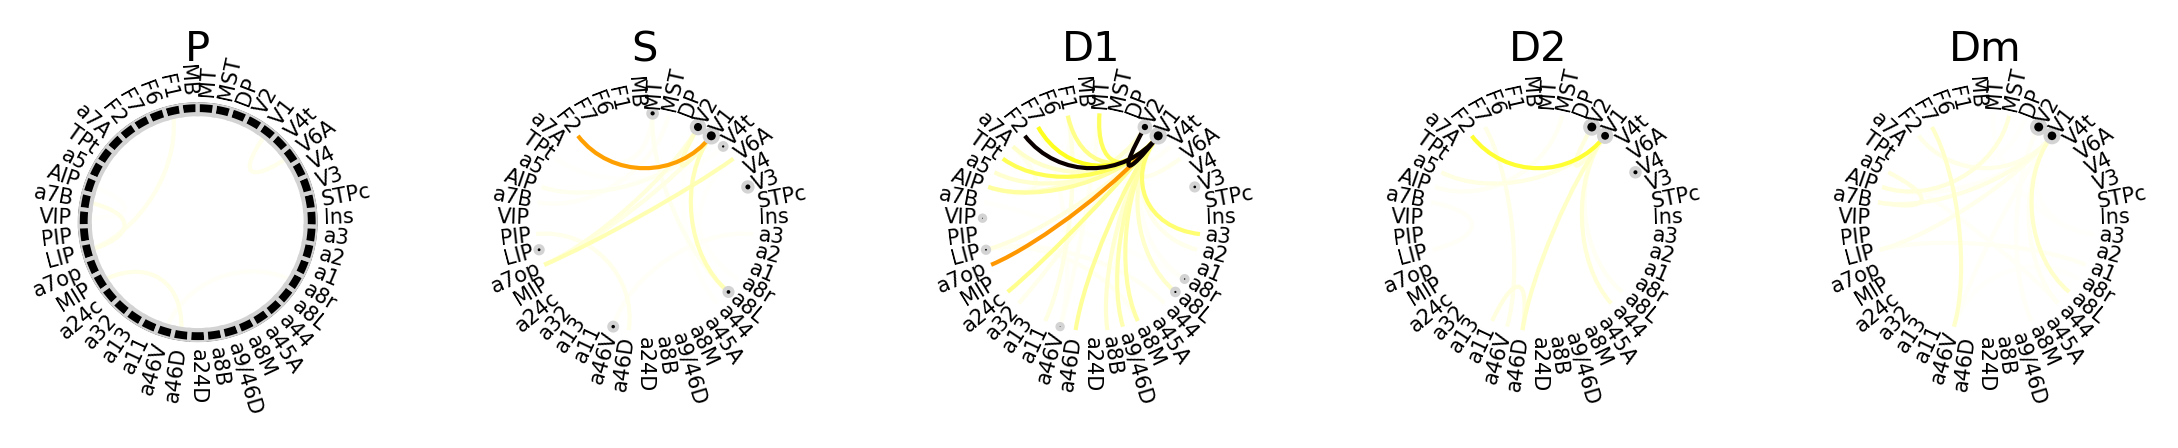

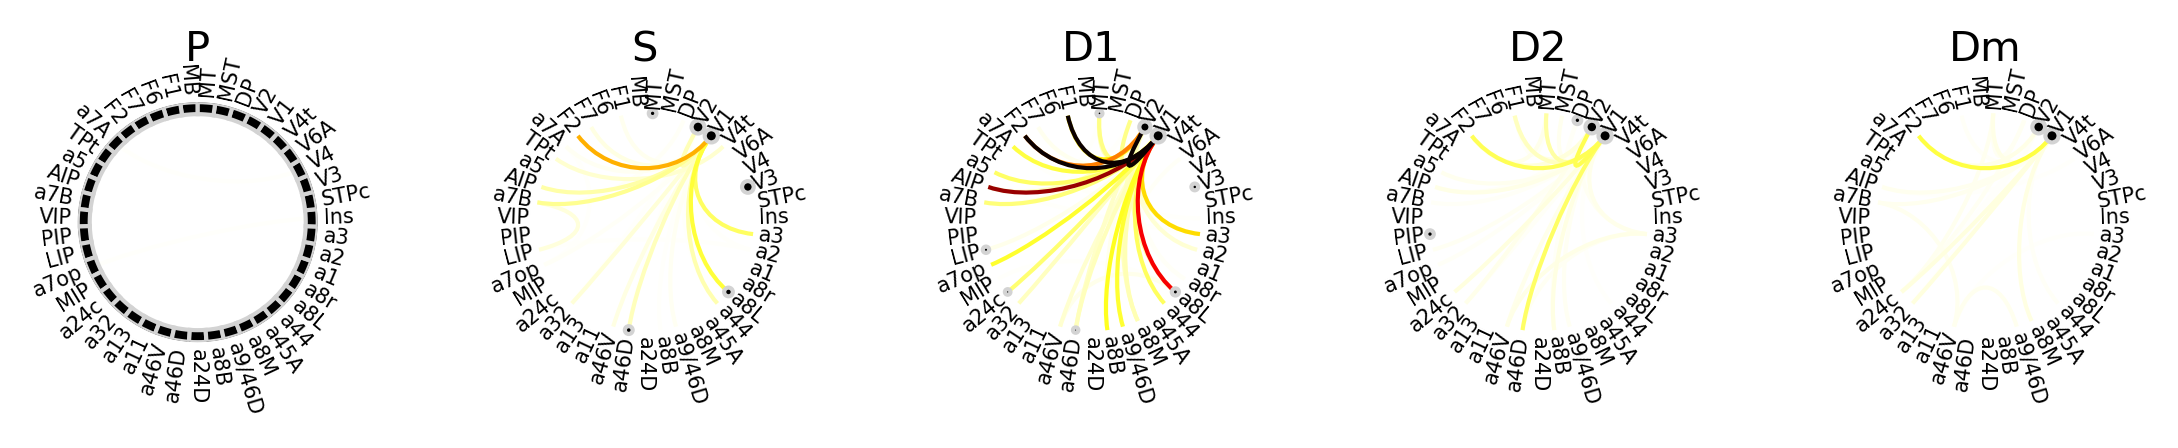

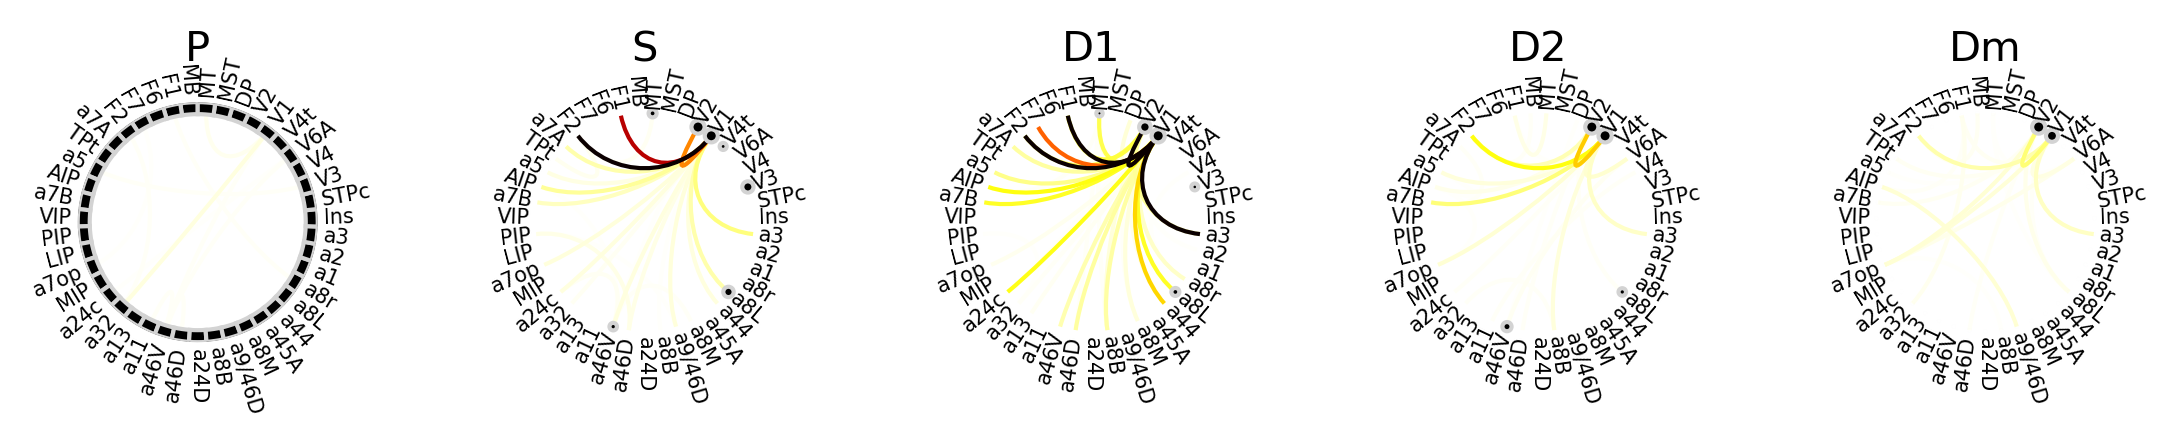

In [47]:
for freq in freqs:
    fig = plt.figure(figsize=(8, 4), dpi=300)

    gs2 = fig.add_gridspec(
        nrows=1, ncols=5, left=0.05, right=0.95, bottom=0.05, top=0.25
    )
    axs2 = [plt.subplot(gs2[i], polar=True) for i in range(5)]
    for time, ax in enumerate(axs2):
        plot_circle_encoding(ax, t_coh, t_pow, freq, time)
        plt.title(f"{stage_labels[time]}", fontsize=10, pad=10)

/home/vinicius/Documents/frites/frites/utils/preproc.py:375: RuntimeWarning: invalid value encountered in true_divide
  x_n = x * to_max / xh
/home/vinicius/Documents/frites/frites/utils/preproc.py:375: RuntimeWarning: invalid value encountered in true_divide
  x_n = x * to_max / xh
/home/vinicius/Documents/frites/frites/utils/preproc.py:375: RuntimeWarning: invalid value encountered in true_divide
  x_n = x * to_max / xh
/home/vinicius/Documents/frites/frites/utils/preproc.py:375: RuntimeWarning: invalid value encountered in true_divide
  x_n = x * to_max / xh
/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/vinicius/Documents/frites/frites/utils/preproc.py:375: RuntimeWarning: invalid value encountered in true_divide
  x_n = x * to_max / xh
/home/vinicius/Documents/frites/frites/utils/preproc.py:375: RuntimeWarning: invalid val

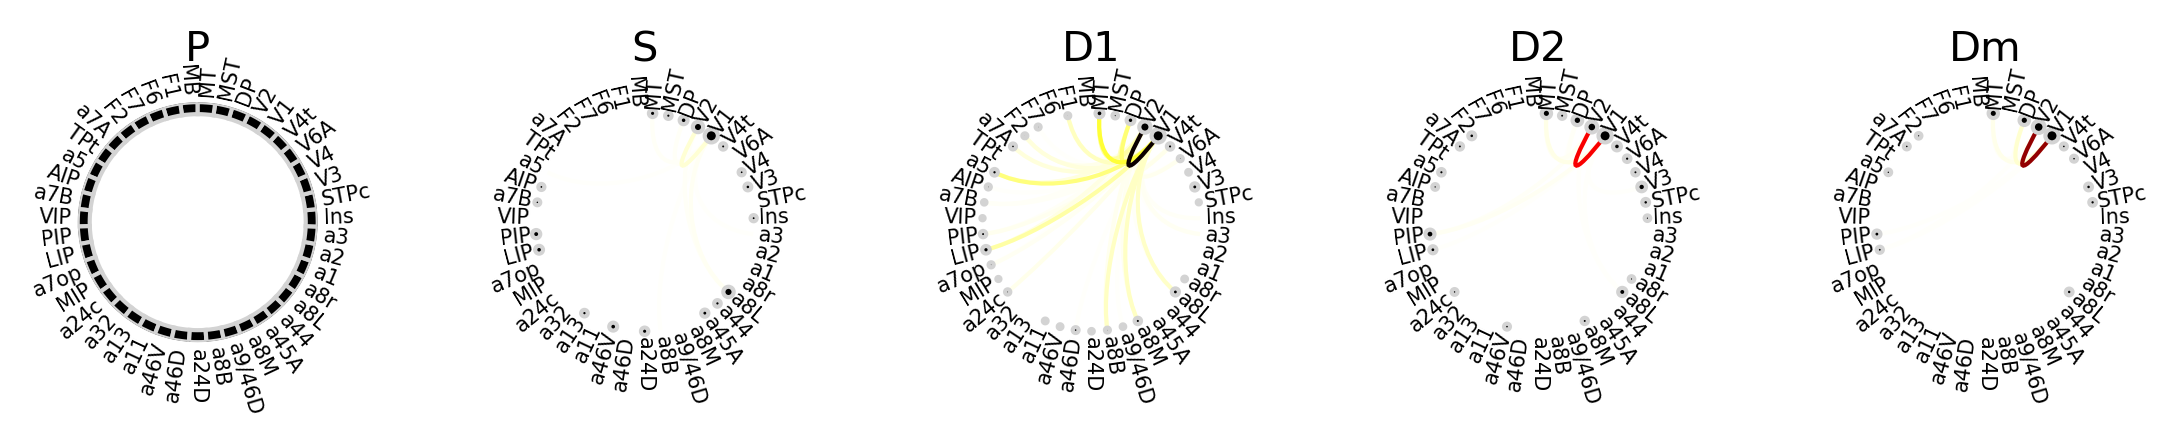

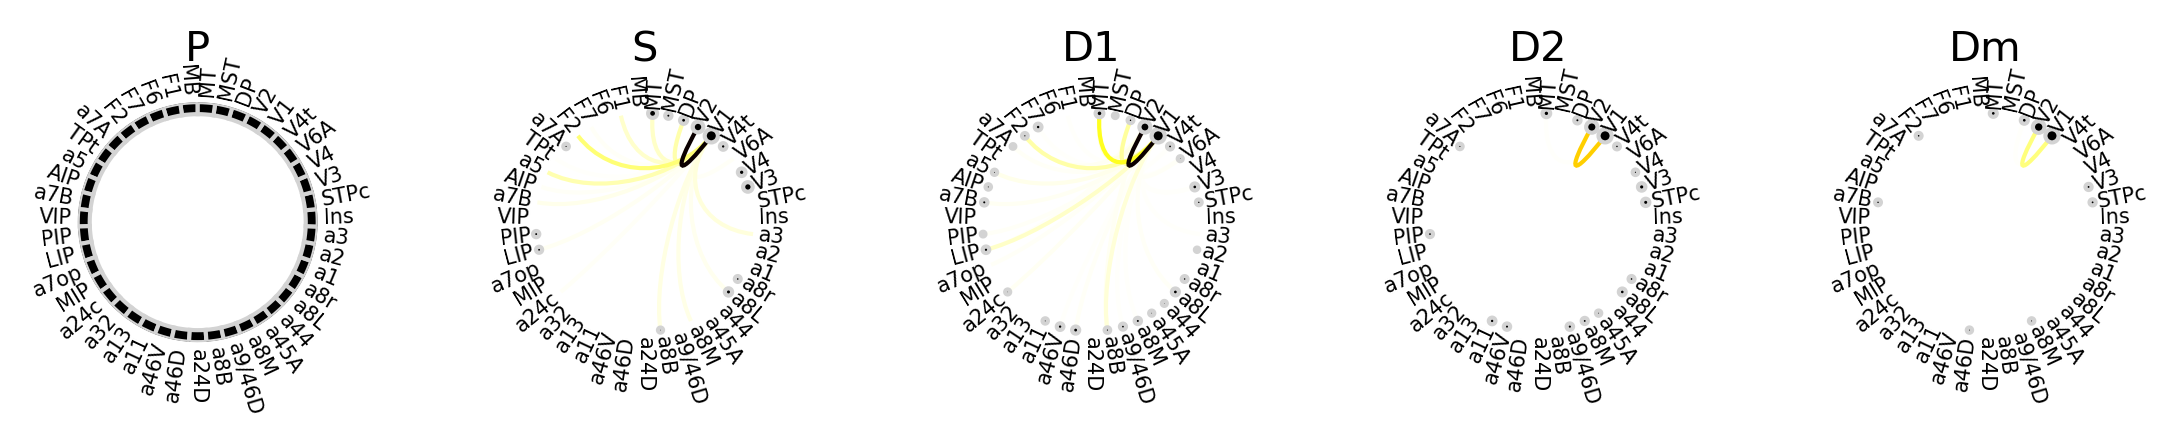

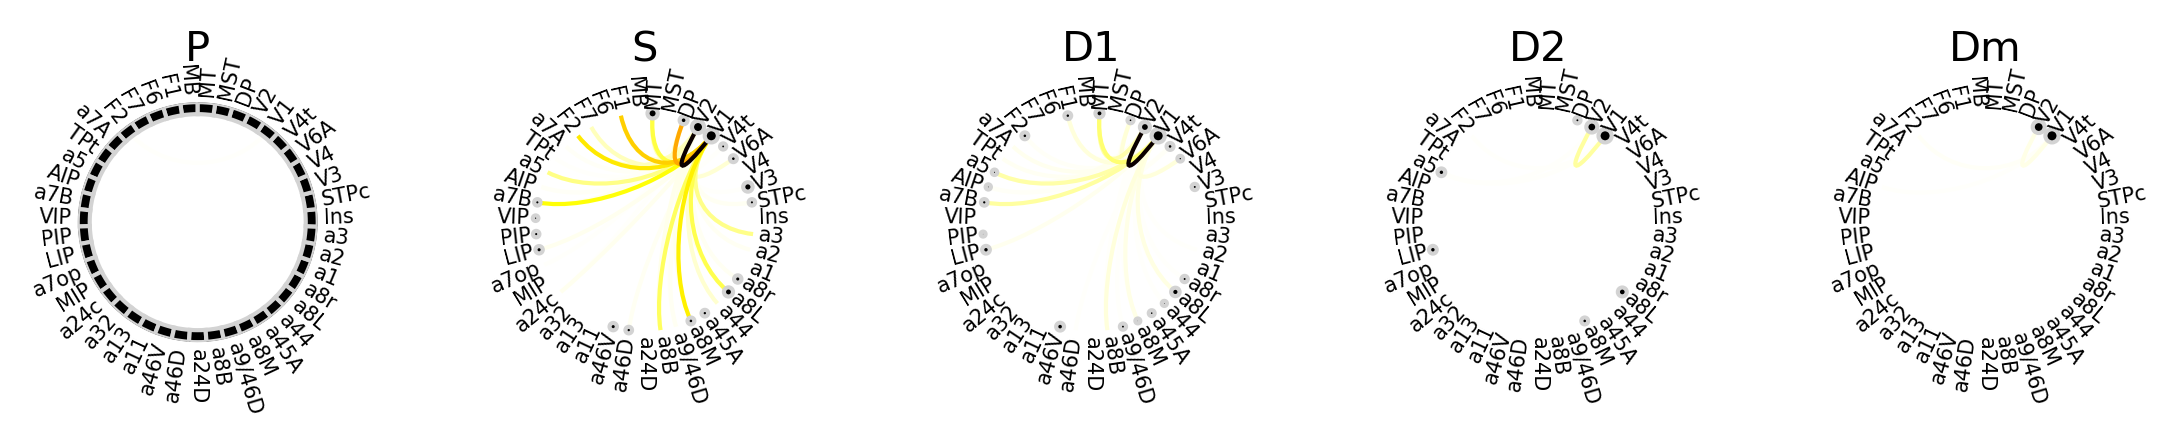

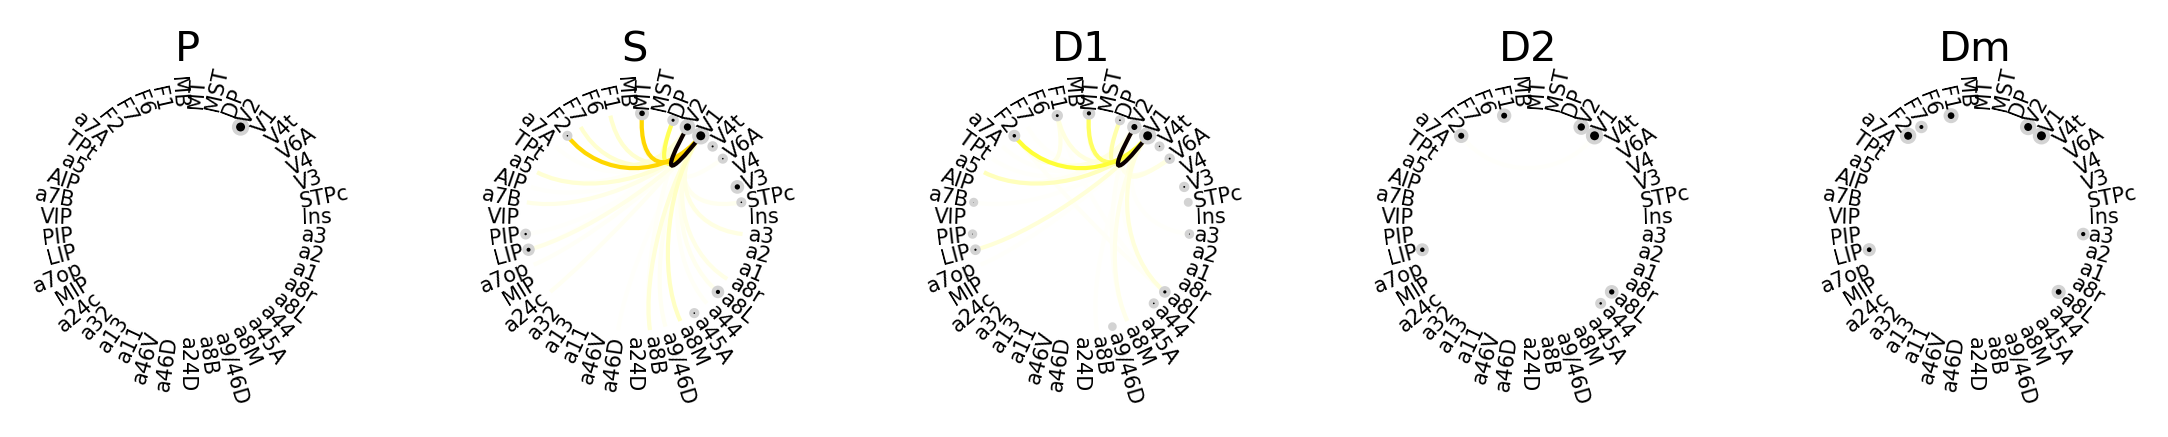

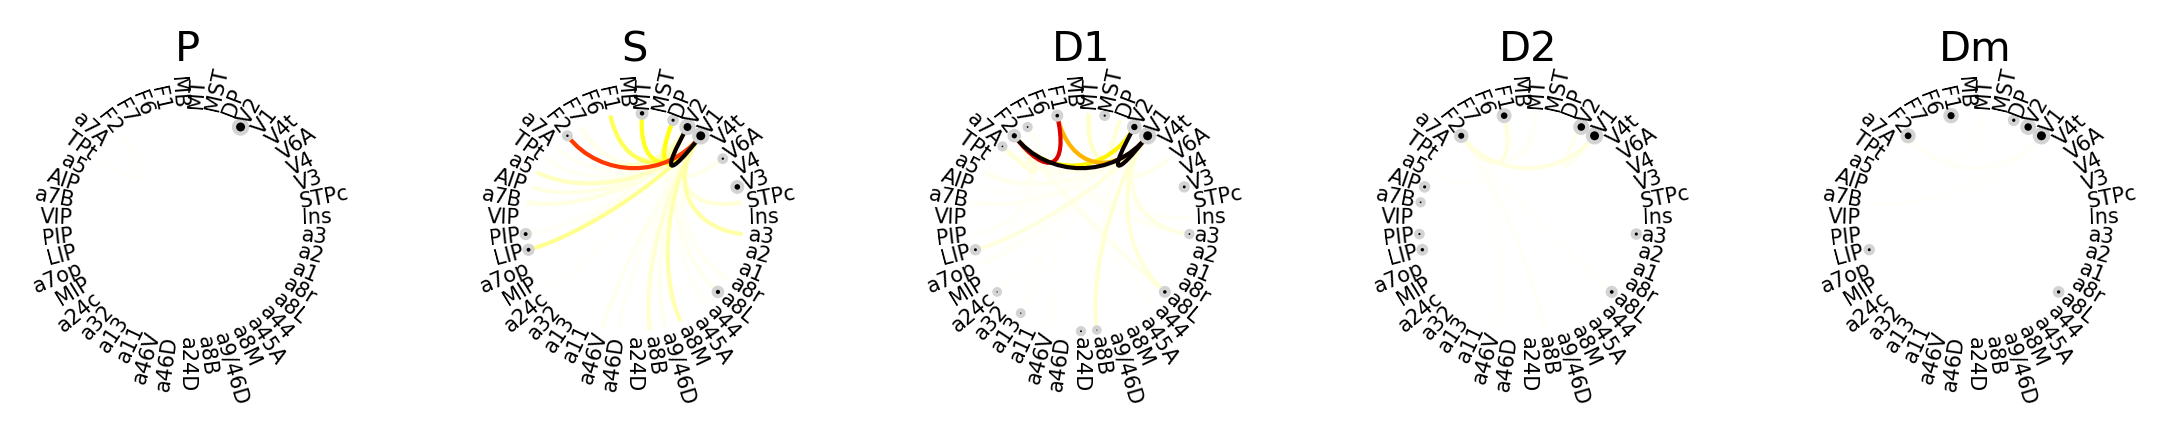

In [ ]:
for freq in freqs:
    fig = plt.figure(figsize=(8, 4), dpi=300)

    gs2 = fig.add_gridspec(
        nrows=1, ncols=5, left=0.05, right=0.95, bottom=0.05, top=0.25
    )
    axs2 = [plt.subplot(gs2[i], polar=True) for i in range(5)]
    for time, ax in enumerate(axs2):
        plot_circle_encoding(ax, t_cc, t_pow, freq, time)
        plt.title(f"{stage_labels[time]}", fontsize=10, pad=10)

In [15]:
##############################################################################
# utility functions
###############################################################################
@nb.jit(nopython=True)
def co_crackling_adj(A):
    """
    Calculate the co-crackling matrix for a given matrix adjacency.

    Parameters:
    A (ndarray): matrix of community assignments where rows are rois and
    columns are time points
    Returns:
    ndarray: 3-D co-crackling matrix, where the last dimension corresponds
    to time point.
    """
    nroi, nobs = A.shape

    out = np.zeros((nroi, nroi, nobs), dtype=np.int8)

    for T in range(nobs):
        idx = A[:, T]
        out[..., T] = np.outer(idx, idx)

    return out


def order_rois(rois, x_s, x_t):
    roi_low = np.asarray([r.lower() for r in rois])
    _xs, _xt = x_s.copy(), x_t.copy()
    x_s, x_t = [], []
    for s, t in zip(_xs, _xt):
        _pair = np.array([roi_low[s], roi_low[t]])
        if np.all(_pair == np.sort(_pair)):
            x_s.append(s)
            x_t.append(t)
        else:
            x_s.append(t)
            x_t.append(s)
    return np.asarray(x_s), np.asarray(x_t)


def co_crackle_mat(A, verbose=False, n_jobs=1):
    """
    Compute co-crackle matrix and consensus vectors for given input data.

    This function computes co-crackle matrix and consensus vectors for the
    given input data. It first computes co-crackling adjacency matrix and then
    computes the mean of the matrix over the observation dimension. Finally,
    it computes consensus vectors for each time step by calling the
    'return_consensus_vector' function.

    Parameters:
    A (xarray.DataArray): Input data.
    nruns (int, optional): Number of runs for consensus vector calculation.
    Default is 100.

    Returns:
    kij (xarray.DataArray): Co-crackle matrix.
    ci (xarray.DataArray): Consensus vector for each time step.
    """
    rois = A.roi.data
    freqs = A.freqs.data
    times = A.times.data
    trials = A.trials.data

    nroi, nfreqs, ntrials, ntimes = A.shape

    A = A.stack(obs=("trials", "times")).data

    def _for_freq(f):
        co_k = co_crackling_adj(A[:, f, :])
        return co_k

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        _for_freq, n_jobs=n_jobs, verbose=False, total=nfreqs
    )
    # Compute surrogate for each frequency
    co_k = parallel(p_fun(f) for f in range(nfreqs))

    co_k = np.stack(co_k, axis=2).reshape((nroi, nroi, nfreqs, ntrials, ntimes))

    x_s, x_t = np.triu_indices(nroi, k=1)
    npairs = len(x_s)
    x_s, x_t = order_rois(rois, x_s, x_t)

    roi_s, roi_t = rois[x_s], rois[x_t]
    roi_st = np.asarray([f"{s}-{t}" for s, t in zip(roi_s, roi_t)])

    co_k_stream = np.zeros((npairs, nfreqs, ntrials, ntimes), dtype=np.int8)

    for p, (i, j) in enumerate(zip(x_s, x_t)):
        co_k_stream[p, ...] = co_k[i, j, ...]

    co_k = xr.DataArray(
        co_k_stream,
        dims=("roi", "freqs", "trials", "times"),
        coords=(roi_st, freqs, trials, times),
    )

    return co_k

In [17]:
tt = br = 1
at = "cue"
q = 0.9
co_k_sessions = []
for s_id in tqdm(sessions):
    _FILE_NAME = f"power_tt_{tt}_br_{br}_at_{at}.nc"
    path_pow = os.path.join(_ROOT, f"Results/{monkey}/{s_id}/session01", _FILE_NAME)
    power = xr.load_dataarray(path_pow)
    attrs = power.attrs

    # Compute activation time-series
    thr = power.quantile(q, ("trials", "times"))
    # Binarized power
    power = (power >= thr).transpose("roi", "freqs", "trials", "times")

    # Computes co-crackling matrices
    co_k = co_crackle_mat(power, verbose=False, n_jobs=10)

    out = []
    for t0, t1 in stages:
        out += [co_k.sel(times=slice(t0, t1)).mean("times")]
    out = xr.concat(out, "times")
    out = out.transpose("trials", "roi", "freqs", "times")
    co_k_sessions += [out.mean("trials")]
    del co_k, out

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  2%|▏         | 1/62 [00:27<27:53, 27.44s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  3%|▎         | 2/62 [00:37<17:29, 17.49s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  5%|▍         | 3/62 [00:52<15:58, 16.24s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  6%|▋         | 4/62 [01:20<19:57, 20.65s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  8%|▊         | 5/62 [02:19<33:00, 34.75s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 10%|▉         | 6/62 [03:23<41:43, 44.70s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 11%|█▏        | 7/62 [03:36<31:25, 34.29s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 13%|█▎        | 8/62 [04:00<27:47, 30.88s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 15%|█▍        | 9/62 [04:32<27:36, 31.25s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 16%|█▌        | 10/62 [05:09<28:31, 32.91s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 18%|█▊        | 11/62 [05:22<22:47, 26.82s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 19%|█▉        | 12/62 [05:46<21:48, 26.17s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 21%|██        | 13/62 [06:10<20:45, 25.42s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 23%|██▎       | 14/62 [06:24<17:39, 22.06s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 24%|██▍       | 15/62 [06:50<18:15, 23.30s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 26%|██▌       | 16/62 [07:09<16:45, 21.85s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 27%|██▋       | 17/62 [07:33<16:51, 22.48s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 29%|██▉       | 18/62 [07:58<17:01, 23.21s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 31%|███       | 19/62 [08:22<16:49, 23.47s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 32%|███▏      | 20/62 [08:55<18:24, 26.29s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 34%|███▍      | 21/62 [09:14<16:35, 24.27s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 35%|███▌      | 22/62 [09:36<15:35, 23.40s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 37%|███▋      | 23/62 [10:09<17:03, 26.25s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 39%|███▊      | 24/62 [10:47<18:54, 29.86s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 40%|████      | 25/62 [11:25<19:55, 32.31s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 42%|████▏     | 26/62 [11:48<17:41, 29.48s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 44%|████▎     | 27/62 [12:05<14:59, 25.69s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 45%|████▌     | 28/62 [12:22<13:08, 23.20s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 47%|████▋     | 29/62 [13:01<15:22, 27.96s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 48%|████▊     | 30/62 [13:14<12:33, 23.53s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 50%|█████     | 31/62 [13:45<13:17, 25.74s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 52%|█████▏    | 32/62 [14:09<12:36, 25.22s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 53%|█████▎    | 33/62 [14:31<11:43, 24.25s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 55%|█████▍    | 34/62 [14:52<10:47, 23.12s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 56%|█████▋    | 35/62 [15:11<09:50, 21.89s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 58%|█████▊    | 36/62 [15:36<09:53, 22.82s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 60%|█████▉    | 37/62 [16:03<10:06, 24.26s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 61%|██████▏   | 38/62 [16:27<09:40, 24.18s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 63%|██████▎   | 39/62 [16:53<09:27, 24.67s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 65%|██████▍   | 40/62 [17:29<10:18, 28.09s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 66%|██████▌   | 41/62 [17:50<09:04, 25.93s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 68%|██████▊   | 42/62 [18:23<09:23, 28.18s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 69%|██████▉   | 43/62 [18:55<09:16, 29.28s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 71%|███████   | 44/62 [19:32<09:27, 31.55s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 73%|███████▎  | 45/62 [19:49<07:39, 27.05s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 74%|███████▍  | 46/62 [20:27<08:06, 30.42s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 76%|███████▌  | 47/62 [20:50<07:03, 28.21s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 77%|███████▋  | 48/62 [21:21<06:47, 29.11s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 79%|███████▉  | 49/62 [21:53<06:27, 29.84s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 81%|████████  | 50/62 [22:11<05:17, 26.44s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 82%|████████▏ | 51/62 [22:33<04:36, 25.18s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 84%|████████▍ | 52/62 [23:01<04:18, 25.89s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 85%|████████▌ | 53/62 [23:25<03:47, 25.23s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 87%|████████▋ | 54/62 [23:57<03:39, 27.41s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 89%|████████▊ | 55/62 [24:29<03:21, 28.76s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 90%|█████████ | 56/62 [24:52<02:41, 27.00s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 92%|█████████▏| 57/62 [25:12<02:04, 24.81s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 94%|█████████▎| 58/62 [25:39<01:42, 25.68s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 95%|█████████▌| 59/62 [25:54<01:07, 22.40s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 97%|█████████▋| 60/62 [26:19<00:46, 23.20s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 98%|█████████▊| 61/62 [26:41<00:22, 22.76s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

100%|██████████| 62/62 [27:05<00:00, 26.22s/it]


In [138]:
out = xr.concat(co_k_sessions, "roi").groupby("roi").mean("roi")

In [139]:
out = out.sel(roi=t_coh.roi)

In [140]:
out = xr_remove_same_roi(out)
tvals = xr_remove_same_roi(t_cc)

In [141]:
rois = out.roi.data
times = out.times.data
freqs = out.freqs.data

In [142]:
nboot = 1000
cc = np.zeros((nboot, len(freqs), len(times)))

for i, freq in enumerate(freqs):
    for j, time in enumerate(times):
        x = out.sel(freqs=freq, times=time)
        y = tvals.sel(freqs=freq, times=time)
        cc[:, i, j] = draw_bs_pairs_reps_pearson(x, y, size=nboot)

cc = xr.DataArray(
    cc, dims=("boot", "freqs", "times"), coords=dict(freqs=freqs, times=times)
)
# cc = confidence_interval(cc, axis=0).squeeze()

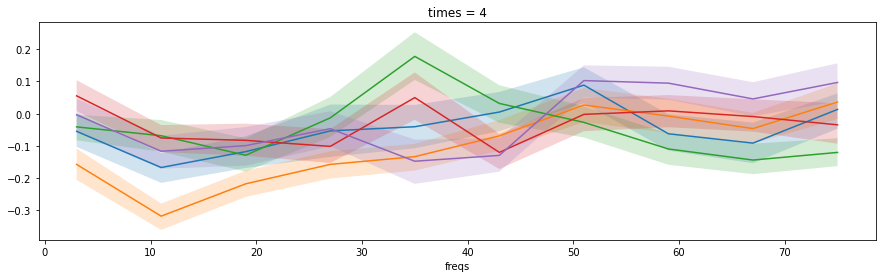

In [143]:
plt.figure(figsize=(15, 4))
for i in range(5):
    cc.median("boot").sel(times=i).plot()
    plt.fill_between(
        freqs,
        cc.sel(times=i).quantile(0.05, "boot"),
        cc.sel(times=i).quantile(0.95, "boot"),
        alpha=0.2,
    )

In [144]:
t_pow

<xarray.DataArray 'tvalues' (freqs: 10, times: 5, roi: 43)>
array([[[-1.9836110e-01, -1.8912526e+00,  3.6893374e-01, ...,
          1.0608594e+00, -9.3123209e-01, -2.0133057e+00],
        [ 1.4071960e+00,  1.2198440e+00,  1.0401874e+00, ...,
          2.0410368e+00,  4.0522041e+00,  4.3102694e+00],
        [ 5.2335515e+00,  3.7376795e+00,  2.3063083e+00, ...,
          3.4563658e+00,  2.1784582e+00,  3.0566452e+00],
        [ 2.4311743e+00,  1.5408279e+00,  6.3666803e-01, ...,
          8.7476134e-01,  6.1897790e-01, -5.3320092e-01],
        [ 1.8618978e+00,  1.2815517e+00,  1.8980703e-01, ...,
          1.0508845e+00,  2.6601335e-01, -9.0972543e-01]],

       [[-7.1317017e-02, -1.6229624e+00,  1.9405330e+00, ...,
          2.7394512e-01, -9.1973871e-01, -1.7559108e+00],
        [ 1.1327438e+00,  2.1332014e+00,  6.6905427e-01, ...,
          2.2567811e+00,  1.5731411e+00,  3.0999619e-01],
        [ 6.6667943e+00,  4.0602274e+00,  2.6936891e+00, ...,
          3.7746522e+00,  3.5074248e+00,  5.1395530e-01],
        [ 2.0046506e+00,  2.1153495e+00, -8.8139158e-01, ...,
          3.7415783e+00,  2.3716786e+00,  1.3466480e+00],
        [ 2.2831845e+00,  1.7397126e+00, -8.7289292e-01, ...,
...
          3.8802516e-01, -1.9935848e-01,  5.6309289e-01],
        [ 3.1314871e+00, -4.5348942e-01, -7.2082525e-01, ...,
          2.1966329e+00,  8.3638442e-01,  5.4399347e-01],
        [ 2.3437214e+00,  8.0113089e-01, -3.8022596e-01, ...,
          6.0609099e-04,  1.7020692e+00,  7.1563423e-02],
        [ 1.5382720e+00, -1.7105457e-01, -1.8655011e-01, ...,
          1.3521028e+00,  1.4173990e+00,  1.2307698e+00],
        [ 2.3319668e-01, -1.8664488e+00,  1.4634833e+00, ...,
          2.7962685e-01,  1.2977195e+00,  2.6170623e-01]],

       [[ 7.2236389e-01, -4.2384782e-01, -1.4298778e+00, ...,
         -4.3659973e-01, -5.9183890e-01, -8.6171317e-01],
        [ 1.9963573e+00, -2.0471482e+00,  1.3540559e+00, ...,
          1.8252593e+00,  8.4849387e-01, -5.7658356e-01],
        [ 1.1608281e+00, -1.2648796e+00,  6.8734229e-02, ...,
         -6.8710029e-02,  2.1344216e+00, -5.1607800e-01],
        [ 2.2146487e-01,  4.8456769e-02, -3.8222253e-01, ...,
         -5.2676862e-01, -1.6674571e-01, -9.8986346e-01],
        [ 5.6752700e-01,  5.8353055e-01, -7.0344517e-03, ...,
         -2.1317651e+00,  5.1676565e-01,  6.1031908e-01]]], dtype=float32)
Coordinates:
  * freqs    (freqs) float64 3.0 11.0 19.0 27.0 35.0 43.0 51.0 59.0 67.0 75.0
  * times    (times) int64 0 1 2 3 4
  * roi      (roi) object 'a46D' 'a8B' 'F6' 'a9/46D' ... 'a11' 'a45A' 'a24D'
Attributes: (12/14)
    mi_type:         cd
    inference:       rfx
    kernel:          None
    ttest_pop_mean:  -0.00042402591148778555
    ttest_sigma:     0.001
    ttest_center:    0
    ...              ...
    cluster_th:      None
    cluster_alpha:   0.05
    ttested:         0
    n_perm:          200
    random_state:    None
    type:            tvalues